In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [16]:
#data = np.load("../data/npy/ES1_R1.npy")

### Synth data

In [5]:
def create_clust(dim):
    center = np.random.random(dim)*np.random.randint(1,50)
    
    #cov_1 = np.random.random((dim,dim))
    #cov_1 += cov_1.T
    #while not all(np.linalg.eigvals(cov_1) > 0):
    #    cov_1 = np.random.random((dim,dim))
    #    cov_1 += cov_1.T
    
    cov_1 = np.diag(np.ones(dim))
    
    return np.random.multivariate_normal(center, cov_1 * 2, 100)

In [6]:
clust_1 = create_clust(4)
clust_2 = create_clust(4)

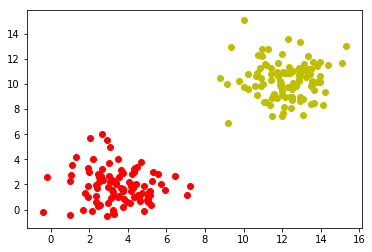

In [7]:
plt.scatter(clust_1[:,0],clust_1[:,1], c='y' )
plt.scatter(clust_2[:,0],clust_2[:,1], c='r' )
plt.show()

In [8]:
data = np.concatenate((clust_1, clust_2))

In [9]:
data.shape

(200, 4)

In [10]:
# Training Parameters
learning_rate = 0.0001
#num_steps = 30000
batch_size = 20
clusters_num = 2

#display_step = 1000
#examples_to_show = 10

# Network Parameters
num_hidden_1 = 10 # 1st layer num features
int_dim = 2 # 2nd layer num features (the latent dim)
num_input = 4 # MNIST data input (img shape: 28*28)

In [33]:
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, int_dim])),
    'decoder_h1': tf.Variable(tf.random_normal([int_dim, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    'predictor_h_1': tf.Variable(tf.random_normal([int_dim + 1, num_hidden_1])),
    'predictor_h_2': tf.Variable(tf.random_normal([num_hidden_1, clusters_num]))
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([int_dim])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    'predictor_b_1': tf.Variable(tf.random_normal([num_hidden_1])),
    'predictor_b_2': tf.Variable(tf.random_normal([clusters_num]))
}

# Building the encoder

    # Encoder Hidden layer with sigmoid activation #1
enc_layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
z = tf.nn.sigmoid(tf.add(tf.matmul(enc_layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))


# Building the decoder

    # Decoder Hidden layer with sigmoid activation #1
dec_layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(z, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
decoder = (tf.add(tf.matmul(dec_layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))

In [34]:
mse = tf.reduce_mean((decoder - X)**2, 1)

predictor_inp = tf.concat([z, tf.reshape(mse, (-1,1))], axis = 1)

In [35]:
predictor_layer_1 = tf.nn.relu(tf.add(tf.matmul(predictor_inp, weights['predictor_h_1']),
                                   biases['predictor_b_1']))
gamma = tf.nn.softmax(tf.add(tf.matmul(predictor_layer_1, weights['predictor_h_2']),
                                   biases['predictor_b_2']))

In [36]:
def est_gmm(gamma, z):
    weights = tf.reduce_mean(gamma, reduction_indices=[0])
    means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))
    
    z_minus_means = tf.map_fn(lambda x: z - x, means)

    def internal(x):
        x = tf.reshape(x, (1,-1))
        return tf.matmul(tf.transpose(x), x)

    matrixes = tf.map_fn(lambda x: tf.map_fn(internal, x), z_minus_means)
    
    m_r = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim))
    m_r2 = tf.reshape(matrixes, (clusters_num * batch_size, int_dim * int_dim)) * tf.reshape(tf.transpose(gamma), (clusters_num * batch_size,1))
    m_r3 = tf.reduce_sum(tf.reshape(m_r2, (clusters_num,batch_size,int_dim,int_dim)), [1]) 
    sigmas = tf.reshape(tf.transpose(tf.transpose(tf.reshape(m_r3, (clusters_num, int_dim * int_dim))) / tf.reduce_sum(gamma, 0)), (clusters_num,int_dim,int_dim))
    
    means_minus_z = tf.map_fn(lambda x: means - x, z)
    
    def internal_e_1(z):
        #return (-0.5 * tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), z[1]), tf.reshape(x, (-1,1))), z[0]), 0.)
        #return tf.map_fn(lambda x,y: (tf.matmul(tf.reshape(x, (1, -1)), y), 0.), (z, sigmas), dtype=(tf.float32, tf.float32))[0]
        return tf.exp( -0.5 * 
            tf.map_fn(lambda x: tf.matmul(tf.matmul(tf.reshape(x, (1, -1)), tf.linalg.inv(z[1])),  tf.reshape(x, (-1, 1))),
                      z[0])) / tf.sqrt(tf.abs(tf.linalg.det(z[1])))

    #en_1 = tf.map_fn(lambda x: tf.transpose(x, (1,0,2)),means_minus_z)#, dtype=(tf.float32, tf.float32))
    en_1 = tf.transpose(means_minus_z, (1,0,2))

    en_2 = tf.map_fn(internal_e_1, (en_1, sigmas), dtype=(tf.float32))

    en = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.transpose(tf.reshape(en_2, (clusters_num, batch_size))) * weights, 1)))
    
    return weights, means, sigmas, en

In [37]:
w, m, s, e = est_gmm(gamma, z)

In [39]:
# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(mse) + 1 * e# + 0.001 / tf.reduce_sum(sigma_flat)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [40]:
sess.close()

In [41]:
sess = tf.Session()
sess.run(init)

# Training

In [42]:
epochs = 10
losses = []

In [43]:
sess.run([mse, e, s], feed_dict={X: data[90:110]})

[array([ 144.29673767,  139.64575195,  135.72424316,  148.22106934,
         139.37278748,  138.16400146,  140.21508789,  147.70288086,
         169.83377075,  135.6854248 ,   13.11942863,   16.82543373,
          35.44166565,   26.55672455,   19.24661636,   23.30073929,
          26.49980927,   30.99579811,   35.77031708,   25.04833221], dtype=float32),
 -5.9684167,
 array([[[  5.35464613e-03,   1.25352363e-03],
         [  1.25352363e-03,   4.58867376e-04]],
 
        [[  3.19405081e-04,   2.80088643e-05],
         [  2.80088643e-05,   2.82154497e-06]]], dtype=float32)]

In [44]:
s

<tf.Tensor 'Reshape_28:0' shape=(2, 2, 2) dtype=float32>

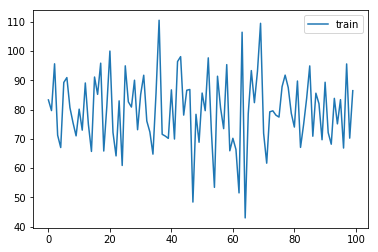

In [45]:
for i in range(epochs):
    for batch in iterate_minibatches(data, batch_size, shuffle = True):
        _, l = sess.run([optimizer, loss], feed_dict={X: batch})
        losses.append(l)
    # Display logs per step
    
    if i % 1 == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        
        display.clear_output(wait=True)
        plt.plot(losses, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()


In [46]:
sess.run([gamma], {X: data[90:110]})

[array([[  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+00,   0.00000000e+00],
        [  9.99997735e-01,   2.20566994e-06],
        [  1.00000000e+00,   4.95495129e-08],
        [  1.00000000e+00,   4.20500295e-16],
        [  1.00000000e+00,   3.20998133e-12],
        [  1.00000000e+00,   4.89824004e-09],
        [  1.00000000e+00,   7.14715925e-11],
        [  1.00000000e+00,   3.23290591e-12],
        [  1.00000000e+00,   3.75343135e-14],
        [  1.00000000e+00,   3.09243603e-16],
        [  1.00000000e+00,   1.46156420e-11]], dtype=float32)]

In [31]:
data[0]

array([ 0.70239951,  0.86487025])

In [32]:
sess.graph.

In [10]:
summ_writer = tf.summary.FileWriter("/home/anton/TF_logs/CRISPR/", sess.graph, filename_suffix="AE")

In [37]:
summ_writer.close()

In [24]:
#gamma = tf.placeholder(tf.float32)
#z = tf.placeholder(tf.float32)    

weights = tf.reduce_mean(gamma, reduction_indices=[0])
means = tf.transpose(tf.matmul(tf.transpose(z), gamma) / tf.transpose(tf.reduce_sum(gamma, reduction_indices=[0])))

z_minus_means = tf.reshape(tf.map_fn(lambda x: z - x, means), [-1, int_dim])

z_minus_means_squared = tf.map_fn(lambda x: tf.reduce_sum(x * x), z_minus_means)

sigma_flat = tf.reduce_sum(tf.transpose(tf.reshape(
        z_minus_means_squared * tf.reshape(tf.transpose(gamma), (1, -1)), [clusters_num, batch_size])), 0) / tf.reduce_sum(gamma, 0)

pre_energy = tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat),1 )
                           
energy = tf.reduce_mean(-tf.log(tf.reduce_sum(tf.exp(-0.5 * tf.transpose(
    tf.reshape(z_minus_means_squared,  [clusters_num, batch_size])) / sigma_flat) * weights  / tf.sqrt(6.28  * sigma_flat), 1)))